In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm

import torch.nn.functional as F
import pytorch_lightning as pl

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform
from symlie.model.networks.implicit import LinearImplicit
from symlie.model.setup import load_implicitP_statedict
from symlie.model.loss import mmd
from symlie.run import parse_options, main, process_args


In [2]:
def plot_2columns(x_plots, x_titles):

    nrows = len(x_plots)
    batch_size = x_plots[0][0].shape[0]

    x_idx = np.random.randint(0, batch_size, 1)[0]
    fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
    for i, (x_l, x_r) in enumerate(x_plots):

        x_l, x_r = x_l.detach().cpu().numpy(), x_r.detach().cpu().numpy()

        for j, (x_lr, color) in enumerate(zip([x_l, x_r], ['tab:blue', 'tab:orange'])):
            xx = x_lr[x_idx]
            ax = axs[i, j]
            ax.plot(xx, 'o-', color = color)
            ax.plot([len(xx)-1, len(xx)], [xx[-1], xx[0]], '--', color=color)
            ax.plot([-1, 0], [xx[-1], xx[0]], '--', color=color)
            ax.set_xticks([])
            ax.set_yticks([0])
            ax.set_title(x_titles[i][j])
    plt.show()

In [3]:
args = parse_options(notebook=True)

args.noise_std = 1.
args.grid_size = (1, 7)
args.eps_mult = [0.0, 0.0, 1.0, 0.0]
args.data_dir = '../data/noise'
args.net = 'TrainP'

args.do_return = True
args.logger = None

args.n_train = 16*1000

process_args(args)

# Training
model, trainer, datamodule = main(args)

Seed set to 42


Initializing generator with size 7
Running without logging


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [4]:
trainloader = datamodule.train_dataloader()

In [5]:
class MLP(nn.Module):
  
  def __init__(self, size=3):
    super().__init__()
    self.size = size
    features = size**2
    self.layers = nn.Sequential(
      nn.Linear(features,features),
      nn.ReLU(),
      nn.Linear(features,features),
      nn.ReLU(),
      nn.Linear(features,features),
      nn.ReLU(),
      nn.Linear(features,features),
    )
    
  def forward(self, x):
    x = x.view(self.size**2)
    x = self.layers(x)
    x = x.view(self.size, self.size)
    return x

torch.manual_seed(torch.randint(0, 1000, (1,)).item())

size = 7
# Initialize the MLP
mlp = MLP(size=size)

# Define the loss function and optimizer
criterion     = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

losses = []

# Run the training loop
for epoch in tqdm(range(0, 15)): # 5 epochs at maximum
    
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get inputs
        x, _, _ = data
        batch_size = x.size(0)
        
        # Zero the gradients
        optimizer.zero_grad()

        weight = torch.rand(size, size)

        x_a = x
        x_b = x
        shift = (torch.rand((1))*size).int().item()

        o_a = x_a @ mlp(weight).T
        o_a_prime = torch.roll(o_a, shift, 1)

        x_b_prime = torch.roll(x_b, shift, 1)
        o_b_prime = x_b_prime @ mlp(weight).T

        # Compute loss
        loss = criterion(o_a_prime, o_b_prime)

        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
    current_loss = current_loss / len(trainloader)
    losses.append(current_loss)
    

100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


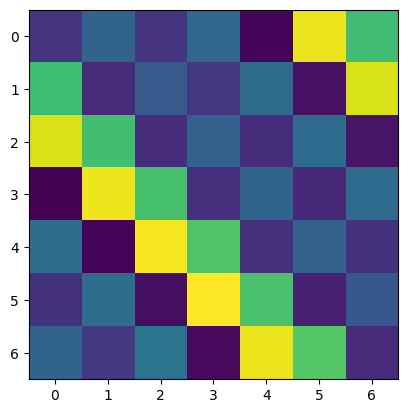

In [11]:
weight = torch.rand(size, size)
plt.imshow( mlp(weight).detach().cpu().numpy() )


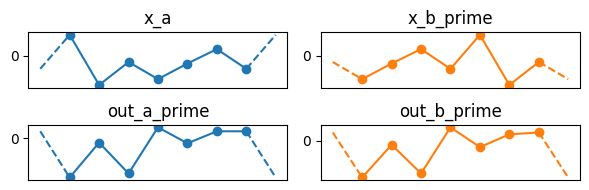

In [6]:
x_plots = [
    [x_a, x_b_prime],
    [o_a_prime, o_b_prime],
]

x_titles = [
    ['x_a', 'x_b_prime'],
    ['out_a_prime', 'out_b_prime'],
]

plot_2columns(x_plots, x_titles)


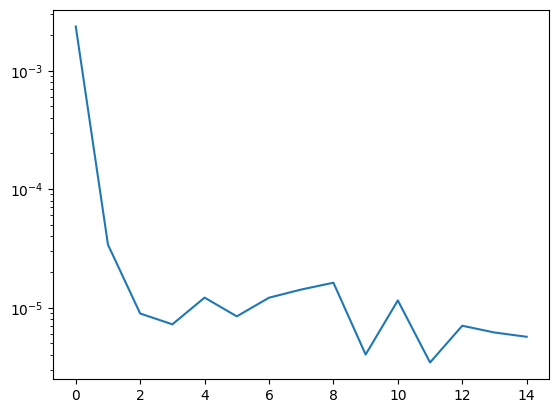

In [7]:
plt.plot(losses, label='o')
plt.yscale('log')
plt.show()